## Social vulnerability and Covid-19 in Chile

0. A first look at the DataFrames
1. Covid-19 in Chile
    1. Covid-19 in Chile and worldwide
    2. Timeline of Covid-19 cases and deaths in Chile 
    3. Which are the 10 most affected districts in Chile, regarding cases and deaths
    
2. The CASEN data

In [2]:
# Read in libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# Read in CASEN data about social vulnerability
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 in Chilen regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True
)


deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True
)

# Read in data about Covid-19 in Chilean districts
cases_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv'
)

cases_districts = cases_districts[~cases_districts.Comuna.str.contains('Desconocido')]


deaths_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto38/CasosFallecidosPorComuna.csv'
)

deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Desconocido')]
deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Total')]



# Read in data about Covid-19 worldwide
csse_cases_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
csse_deaths_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [56]:
# Select only 46 relevant indicators from the CASEN study, such as poverty, access to health institutions or
# number of persons in household. 

casen_columns = ['region', 'provincia', 'comuna', 'e1', 'e6a', 'o1', 'o12', 'o16', 'o25a_min',
                'o25c', 'o28', 'y21a', 'y22a', 'y24', 'y27a', 'ysub', 'ytot', 's12', 's13', 's14', 
                's26a', 's27a', 's28', 's31a1', 's32c', 's33g1', 's33i1', 's33j1',
                'r1a', 'r3', 'r7c', 'r8a', 'r8b', 'r16a', 'r16b', 'v33', 'v37a', 'v37c',
                'v37i', 'v39b', 'pobreza', 'hh_d_prevs', 'hh_d_cot', 'hh_d_servbas', 'qaut', 'numper']

casen_rel = casen[casen_columns]

In [52]:
def first_look(lst):
    """
    Provides useful information about a list of dataframes: Name, Shape, NaNs and describe().
    
    Input: 
        lst(List): List of DataFrames
    
    Output: 
        Prints name, shape, share of NaNs, describe()
    """
    for item in lst:
        def get_df_name(df):
            name =[x for x in globals() if globals()[x] is df][0]
            return name
        print('Information for DataFrame ' + get_df_name(item))
        print('The shape of this DataFrame is {}.'.format(item.shape))
        print('NaN share for each column:')
        print((np.sum(item.isna() == True))/item.shape[0])
        print('Describe() for each column:')
        print(item.describe())
        print('---')

In [4]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): A transposed DataFrame where the first row (not the index) is the date and the columns are the 
        regions. 
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name='Cases'
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values('Cases', ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    g = sns.lineplot(
        df_melt.Date, 
        df_melt.Cases, 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('{}'.format(title), fontsize = 12)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 12)
    
    plt.tick_params(labelsize=12)
    ax.yaxis.tick_right()
    ax.set_yscale('log')


    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()
            

In [15]:
def plot_covid_worldwide(df, title, country, m):
    """
    Function to plot a comparison between the m-most affected countries (as per 100.000 habitants) 
    and a specific country, which is highlighted in red. 
    
    If the specific country is not wihtin the m-most affected countries, it is appended at the end. 
    
    Input: 
        df (DataFrame): DataFrame with country data
        title (string): Specify the kind of the plot (cases or deaths) 
        country (string): The country that sould be highlighted
        m (int): Returns the m-most affected countries. 
        
    Output: 
        A seaborn plot. 
    """
    
    # Get the relevant columns of df (Countryname and total number) and add a new column
    # of cases/deaths per 100.000 habitants. Rename the columns. 
    df_current = df.iloc[:, [1, -1]]
    df_current.columns = ['Country', title]
    df_current.loc[:, 'per 100.000'] = df_current.loc[:, title] / 100000

    # Groupby country and get the m-most affected countries. 
    df_current = df_current.groupby(
        'Country')[
        'per 100.000'].sum().reset_index().sort_values([
        'per 100.000'], ascending = False)
    
    df_current_head = df_current.head(m)

    # Check if specific country is part of the m-most affected countries
    if country in list(df_current_head.Country) == True:

        # Get index of specific country in country list
        index = list(df_current_head.Country).index(country)

        # Plot the figure
        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_current_head['Country'], x = df_current_head['per 100.000'], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per 100.000 habitants'.format(title), fontsize = 12)
        plt.title('Covid-19 {} per 100.000 habitants worldwide'.format(title), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()


    # If the specific country is not within the m-most affected countries, append it to the list
    else:

        df_current_head = df_current_head.append(df_current[df_current['Country'] == country])
        index = list(df_current_head.Country).index(country)

        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_current_head['Country'], x = df_current_head['per 100.000'], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per 100.000 habitants'.format(title), fontsize = 12)
        plt.title('Covid-19 {} per 100.000 habitants worldwide'.format(title), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()

In [26]:
def get_most_affected_districts(df, title, m):
    """
    Function to get the most affected districts.
    
    Input: 
        df (DataFrame): DataFrame with information about districts and numbers of cases/deaths
        title (string): Specify the kind of the data (cases or deaths)
        m (int): Returns the m-most affected districts.
        
    Output:
        most_affected (DataFrame): DataFrame with the m-most affected districts
    """

    # Get the relevant columns from dataframe and rename them
    df_relevant = df.iloc[:, [0, 2, -2]]
    df_relevant.columns = ['Region', 'District', title]
    
    # Group by District and drop "index" column
    most_affected = df_relevant.groupby(
        'District').agg({
        'Region': 'max', title: 'sum'}).reset_index().sort_values(
        title, ascending = False).head(10).reset_index()
    
    most_affected = most_affected.drop(['index'], axis = 1)  
    
    return most_affected

## 0. A first look at the DataFrames

A first look at the DataFrames shows that the CASEN data has a lot of NaNs. E.g. the variable s32c ('Do you have difficulties with moving within your house?') has a very high percentage of NaNs. Other possible variables (option 2 and 3 for 'permament conditions'), that I found interesting at first, had more than 97% of NaNs which is why I dropped them.  

Interestingly, other indicators that are about not having enough money to buy food or having a water heater at home have the same share of NaNs, which is 67%. 

In [57]:
df_list = [casen_rel, cases_regions, deaths_regions, cases_districts, deaths_districts, csse_cases_all, csse_deaths_all]

first_look(df_list)

Information for DataFrame casen_rel
The shape of this DataFrame is (216439, 46).
NaN share for each column:
region          0.000000
provincia       0.000000
comuna          0.000000
e1              0.191107
e6a             0.000000
o1              0.191107
o12             0.573011
o16             0.682913
o25a_min        0.573011
o25c            0.625299
o28             0.191107
y21a            0.615448
y22a            0.000000
y24             0.672203
y27a            0.191107
ysub            0.712524
ytot            0.331424
s12             0.000000
s13             0.000000
s14             0.615448
s26a            0.000000
s27a            0.000000
s28             0.000000
s31a1           0.000000
s32c            0.881713
s33g1           0.191107
s33i1           0.191107
s33j1           0.191107
r1a             0.000000
r3              0.000000
r7c             0.672203
r8a             0.672203
r8b             0.672203
r16a            0.672203
r16b            0.672203
v33             0

       Codigo region  Codigo comuna      Poblacion  2020-03-30  2020-04-01  \
count     346.000000     346.000000     346.000000  343.000000  346.000000   
mean        8.797688    9034.997110   56237.890173    5.647230    8.141618   
std         3.847016    3818.147431   88945.967089   19.022787   25.224560   
min         1.000000    1101.000000     137.000000    0.000000    0.000000   
25%         6.000000    6109.250000    9649.250000    0.000000    0.000000   
50%         8.000000    8313.500000   19770.000000    0.000000    0.000000   
75%        13.000000   13102.750000   55441.250000    0.000000    5.000000   
max        16.000000   16305.000000  645909.000000  181.000000  225.000000   

       2020-04-03  2020-04-06  2020-04-08  2020-04-10  2020-04-13  ...  \
count   346.00000  346.000000  346.000000  346.000000  346.000000  ...   
mean     10.15896   13.254335   15.300578   18.138728   21.621387  ...   
std      31.03781   38.455380   42.803249   49.523508   56.388132  ...   
m

              Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean    21.076624   22.829441    0.063910    0.067669    0.097744    0.157895   
std     24.904600   70.191330    1.042337    1.043908    1.473615    2.453621   
min    -51.796300 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      6.677575  -15.277675    0.000000    0.000000    0.000000    0.000000   
50%     22.820850   20.921188    0.000000    0.000000    0.000000    0.000000   
75%     41.143200   77.913685    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000   17.000000   17.000000   24.000000   40.000000   

          1/26/20     1/27/20     1/28/20     1/29/20  ...        7/17/20  \
count  266.000000  266.000000  266.000000  266.000000  ...     266.000000   
mean     0.210526    0.308271    0.492481    0.500000  ...    2242.552632   
std      3.189730    4.660845    7.6642

## 1. Covid-19 in Chile

###     A. Covid-19 in Chile and worldwide

First, lets have a look at the spread of Covid-19 in Chile and worldwide. Therefore, we compare the number of cases and deaths per 100.000 habitants. 

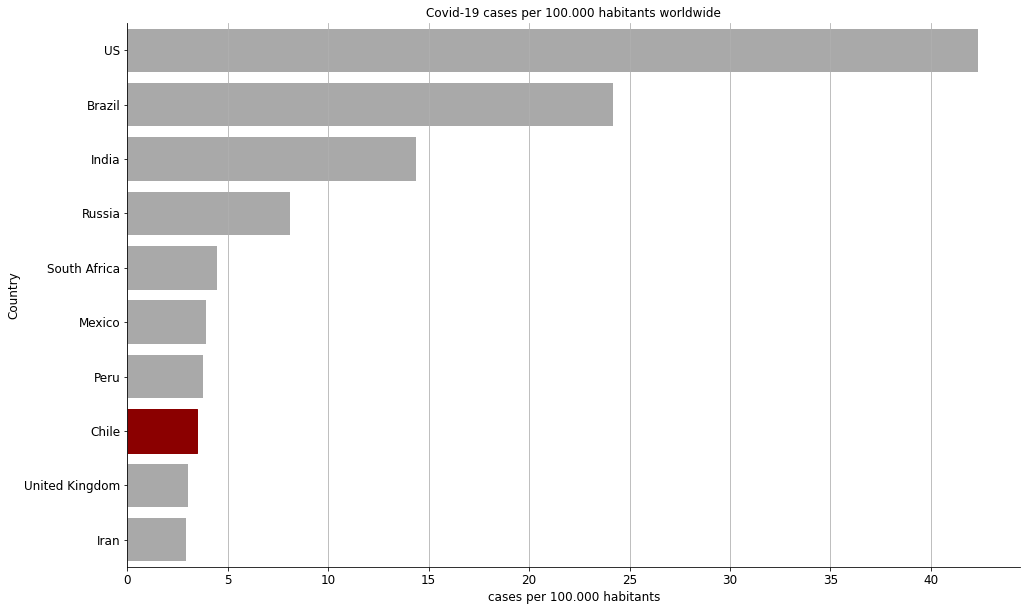

In [16]:
plot_covid_worldwide(csse_cases_all, 'cases', 'Chile', 10)

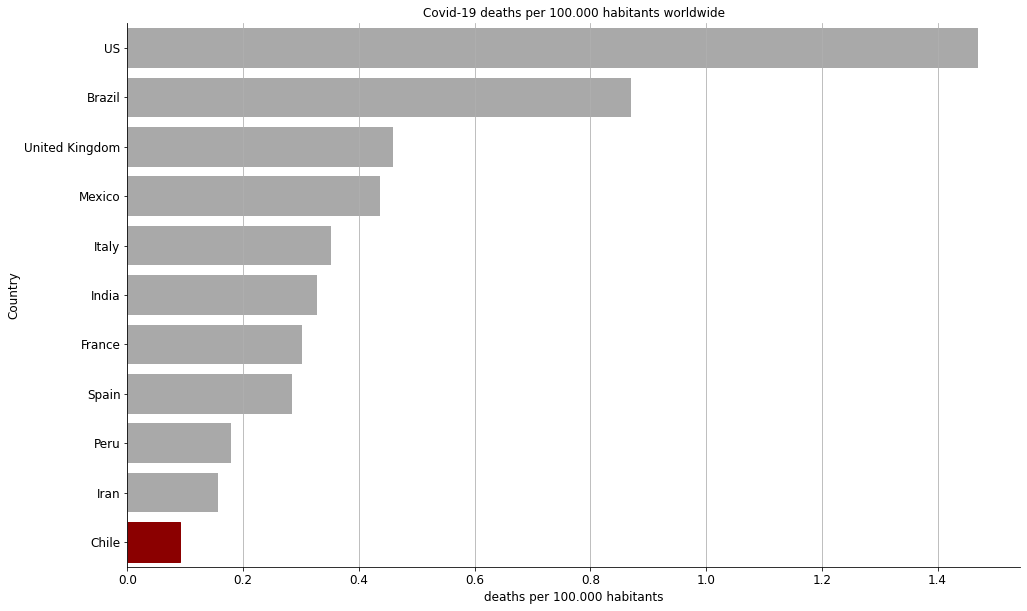

In [17]:
plot_covid_worldwide(csse_deaths_all, 'deaths', 'Chile', 10)

### B. Timeline of Covid-19 cases and deaths in Chile 

Next, we will focus on the situation in Chile. Chile is separated into 16 different regions, where "Metropolitana" is the region where the capital Santiago de Chile is located. 

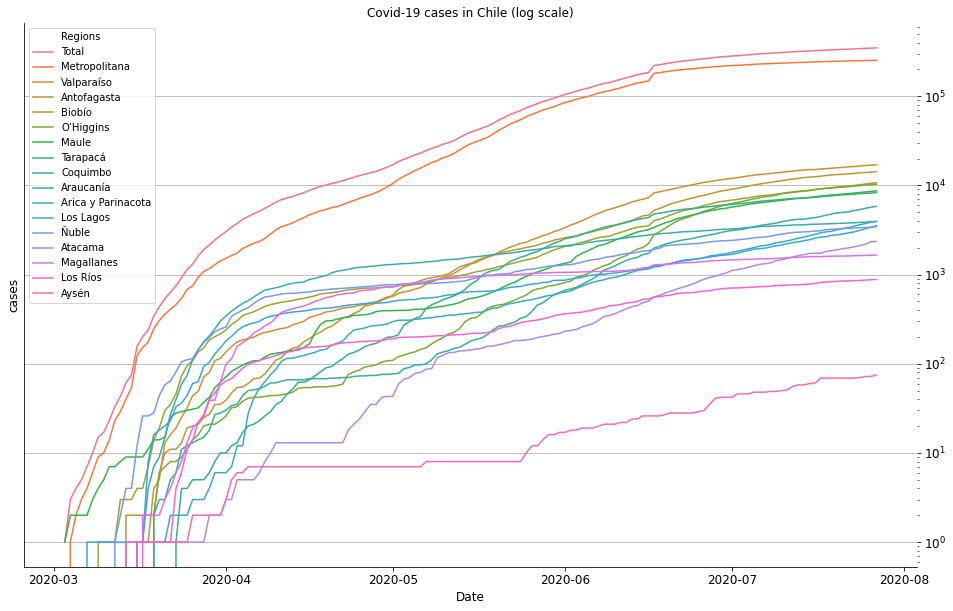

In [9]:
timeline_plot(cases_regions, 'cases')

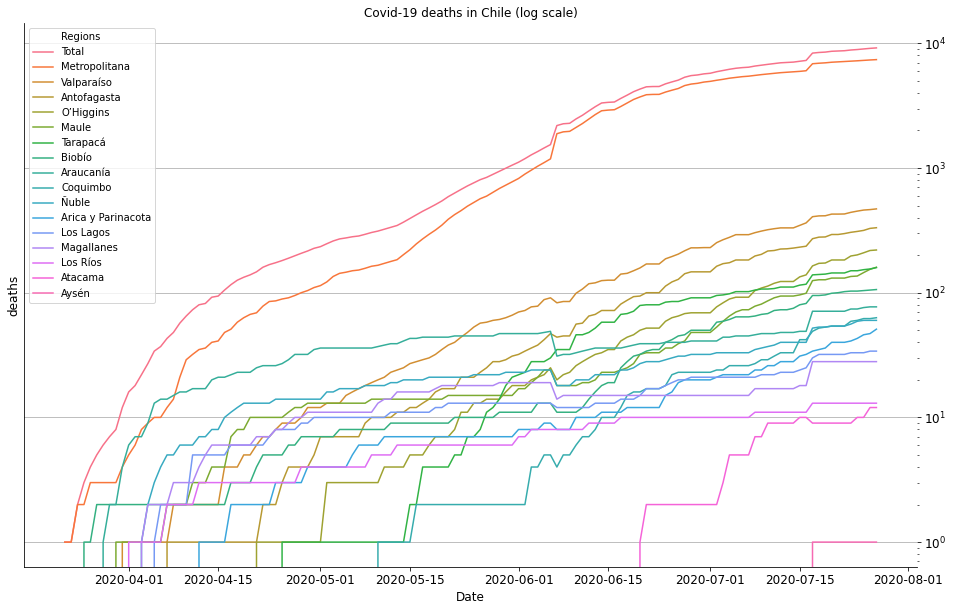

In [10]:
timeline_plot(deaths_regions, 'deaths')

###     B. Which are the 10 most affected districts in Chile, regarding cases and deaths

Looking at the most affected districts in Chile, it is no surprise that they are mainly located in the capital metropolitan zone. 

In [27]:
get_most_affected_districts(cases_districts, 'cases', 10)

,District,Region,cases
0,Puente Alto,Metropolitana,21893.0
1,Santiago,Metropolitana,14329.0
2,Maipu,Metropolitana,13848.0
3,La Florida,Metropolitana,13038.0
4,Penalolen,Metropolitana,11281.0
5,San Bernardo,Metropolitana,10576.0
6,La Pintana,Metropolitana,9677.0
7,Pudahuel,Metropolitana,9368.0
8,Quilicura,Metropolitana,8672.0
9,Recoleta,Metropolitana,8139.0


In [12]:
get_most_affected_districts(deaths_districts, 'deaths', 10)

,District,Region,deaths
0,Puente Alto,Metropolitana,497.0
1,La Florida,Metropolitana,419.0
2,Maipu,Metropolitana,326.0
3,San Bernardo,Metropolitana,288.0
4,La Pintana,Metropolitana,284.0
5,Recoleta,Metropolitana,283.0
6,Penalolen,Metropolitana,275.0
7,Las Condes,Metropolitana,259.0
8,Santiago,Metropolitana,257.0
9,Cerro Navia,Metropolitana,221.0


In [37]:
cases_districts.iloc[:, [-2]].sum()
(casen_rel.isna()).sum()/casen_rel.shape[0]

region          0.000000
provincia       0.000000
comuna          0.000000
e1              0.191107
e6a             0.000000
o1              0.191107
o12             0.573011
o16             0.682913
o25a_min        0.573011
o25c            0.625299
o28             0.191107
y21a            0.615448
y22a            0.000000
y24             0.672203
y27a            0.191107
ysub            0.712524
ytot            0.331424
s12             0.000000
s13             0.000000
s14             0.615448
s26a            0.000000
s27a            0.000000
s28             0.000000
s31a1           0.000000
s31a2           0.976280
s31a3           0.992464
s32c            0.881713
s33g1           0.191107
s33i1           0.191107
s33j1           0.191107
r1a             0.000000
r1a_cod         0.972607
r3              0.000000
r7c             0.672203
r8a             0.672203
r8b             0.672203
r16a            0.672203
r16b            0.672203
v33             0.000000
v37a            0.000000


In [4]:
df.groupby('region').hogar.count().reset_index()#.sort_values('hogar', ascending = False)


,region,hogar
0,1,10150
1,2,8510
2,3,6961
3,4,9952
4,5,19625
5,6,15862
6,7,15208
7,8,21532
8,9,15481
9,10,12442


In [18]:
df_e1 = df.loc[:, ['region', 'comuna', 'ytot']]

df_e1.groupby('comuna').ytot.mean().reset_index().sort_values('ytot', ascending = False)

,comuna,ytot
267,13132,1.987719e+06
249,13114,1.618252e+06
258,13123,1.476416e+06
255,13120,1.081854e+06
248,13113,1.002380e+06
...,...,...
198,9208,1.857542e+05
165,8310,1.854193e+05
163,8308,1.828309e+05
119,7203,1.820784e+05
